# Evaluation of the Model

In [1]:
import os
import sys

parent = os.path.dirname(os.path.abspath(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)
    
parent

'd:\\Documents\\git\\XAI-Cancer-Diagnosis\\XAI-Cancer-Diagnosis'

# Data and Models

In [2]:
train_ind, val_ind = [], []
src_folder = os.path.join(parent, "data", "processed",
                            "BACH_TRAIN")
graph_split = os.path.join(src_folder, "graph_ind.txt")
with open(graph_split, "r") as f:
    l1 = f.readline().strip()
    l2 = f.readline().strip()
    train_ind = list(map(int, l1[1:-1].split(",")))
    val_ind = list(map(int, l2[1:-1].split(",")))

In [3]:
from src.datasets.BACH import BACH
from torch_geometric.loader.dataloader import DataLoader

train_set, val_set = BACH(src_folder, ids=train_ind,pre_encoded=True), BACH(src_folder, ids=val_ind,pre_encoded=True)

def get_class(path_name):
    if "Benign" in path_name:
        return 0
    if "InSitu" in path_name:
        return 1
    if "Invasive" in path_name:
        return 2
    return 3

In [4]:
from src.predict_cancer import predict_cancer
import torch
from src.deep_learning.architectures.cancer_prediction.cancer_gnn import CancerGNN
from torch_geometric.transforms import Compose, KNNGraph, RandomTranslate, Distance

gnn_args = {"HEIGHT": 7, "WIDTH": 32}
graph_trans = Compose([KNNGraph(6)])

gnn_loc=os.path.join(parent,"model", "GCN.ckpt")
gnn_voter = CancerGNN.load_from_checkpoint(gnn_loc, **gnn_args).eval().cuda()

def predict(graph):
    with torch.no_grad():
        pred = gnn_voter.predict(graph.cuda())
        return torch.softmax(pred,dim=1).cpu().numpy()        

#... run predict_cancer on each image (all 400), and save to a csv along with ground truth.

# ... seperate predictions based on train or val. Create Confusion Matrix

## Confusion Matrix

In [5]:
from src.deep_learning.metrics.confusion_matrix import confusion_matrix
from tqdm import tqdm
def cm(data_set):
    Y,Y_HAT =[],[]
    for graph in tqdm(data_set):
        y = graph.y
        y_hat= predict(graph)
        Y.append(y.item())
        Y_HAT.append(y_hat.argmax().item())
    return confusion_matrix(torch.as_tensor(Y),torch.as_tensor(Y_HAT),num_classes=4)
        
    
tcm = cm(train_set)
vcm = cm(val_set)

100%|██████████| 76/76 [00:35<00:00,  2.12it/s]


<AxesSubplot:>

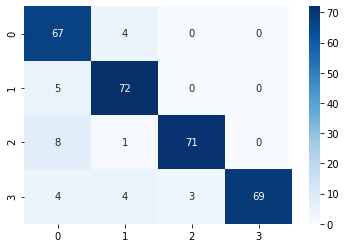

In [7]:
import seaborn as sns
sns.heatmap(tcm, annot=True, fmt=".0f", cmap="Blues")

<AxesSubplot:>

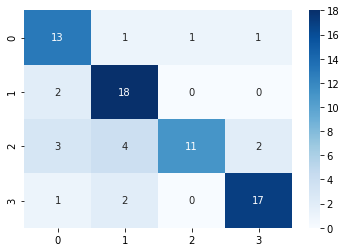

In [8]:
sns.heatmap(vcm, annot=True, fmt=".0f", cmap="Blues")

In [11]:
def print_accuracy(cm):
    total = cm.sum()
    four_class_correct = cm.trace()
    print(f"Total of {total} images")    
    print(f"Four class Accuracy: {four_class_correct/total} - {four_class_correct}")
   # For two class_correct, treat 0 and 1 as same and 2 and 3 as same
    two_class_correct = cm[:2,:2].sum() + cm[2:,2:].sum()
    print(f"Two class Accuracy: {two_class_correct/total} - {two_class_correct}")
print_accuracy(tcm)
print_accuracy(vcm)

Total of 308 images
Four class Accuracy: 0.9058441519737244 - 279
Two class Accuracy: 0.9448052048683167 - 291
Total of 76 images
Four class Accuracy: 0.7763158082962036 - 59
Two class Accuracy: 0.8421052694320679 - 64
